In [1]:
import os
import requests
import json
import pandas as pd
import time
import matplotlib.pyplot as plt
from matplotlib import rc
from bs4 import BeautifulSoup
import nltk
from nltk import Text
from nltk.tag import pos_tag
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from konlpy.tag import Hannanum, Kkma, Komoran, Twitter, Okt
from wordcloud import WordCloud
from konlpy.corpus import kolaw
from keras_preprocessing.text import Tokenizer
import re
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, RNN, Dense

In [2]:
pd.set_option('display.max_rows', None)  # 최대 행 수 제한 해제
pd.set_option('display.max_columns', None)  # 최대 열 수 제한 해제
pd.set_option('display.width', None)  # 자동 너비 조정 해제
pd.set_option('display.max_colwidth', None)  # 최대 컬럼 너비 해제

In [3]:
os.environ.get('JAVA_HOME')

'/Library/Java/JavaVirtualMachines/jdk-17.jdk/Contents/Home'

In [4]:
%ls

?DNN.ipynb
KOSIS/
csv_file/
data_go_kr/
jpype1-1.5.1-cp312-cp312-macosx_10_9_universal2.whl
openAPI_자연어처리_RNN.ipynb


In [5]:
! pip install jpype1-1.5.1-cp312-cp312-macosx_10_9_universal2.whl

Processing ./jpype1-1.5.1-cp312-cp312-macosx_10_9_universal2.whl
jpype1 is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.


In [6]:
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/imsehyeon/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/imsehyeon/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/imsehyeon/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# openAPI를 이용하여 뉴스 기사 검색

In [7]:
# API 호출을 위한 설정
client_id = 'RgKYwTbMqCx5s9yGYqsT'
client_secret = '1INoZ2YkcD'
query = '흡연구역'
items_list = []

# 네이버 뉴스 API 호출
url = f'https://openapi.naver.com/v1/search/news.json?query={query}&display=30'
headers = {'X-Naver-Client-Id' : client_id, 'X-Naver-Client-Secret' : client_secret}
response = requests.get(url, headers=headers)

# 뉴스 아이템 리스트 추출
items = json.loads(response.text)['items']

# 각 뉴스의 제목, 링크, 설명, 본문을 추출
for item in items:
    title = item['title'].replace('<b>', '').replace('</b>', '').replace('&quot;', '')
    link = item['link']
    description = item['description'].replace('<b>', '').replace('</b>', '').replace('&quot;', '')
    
    # 본문 크롤링
    try:
        # 기사 페이지에 접속
        article_response = requests.get(link)
        article_soup = BeautifulSoup(article_response.text, 'html.parser')

        # 뉴스 본문 찾기 (일반적인 뉴스 페이지에서는 본문이 <div class="article_body">로 감싸져 있음)
        # 이 부분은 네이버 뉴스 페이지 구조에 따라 다를 수 있음
        article_content = article_soup.find('div', {'id': 'newsct_article'})
        if article_content:
            article_text = article_content.get_text().strip().replace('\n\n\n\n', '')
        else:
            article_text = "본문을 찾을 수 없습니다."
        
    except Exception as e:
        print(f"Error fetching article from {link}: {e}")
        article_text = "본문을 가져오는 데 실패했습니다."

    # 데이터 추가
    items_list.append([title, link, description, article_text])

# DataFrame으로 변환하여 출력
df = pd.DataFrame(items_list, columns=['title', 'link', 'description', 'content'])

In [8]:
df

,title,link,description,content
0,"부산대병원 부산금연지원센터, 주택관리공단 부산울산지사 ‘금연사업...",https://n.news.naver.com/mnews/article/031/0000902003?sid=102,주택관리공단 부산울산지사는 부산지역 공공임대주택에서 △생활터 금연지원서비스 적극 추진 △입주민 대상 금연캠페인 및 금연상담 프로그램 운영 △공공임대주택 내 상습 흡연구역 개선 △지역사회와 연계한 중독...,부산대학교병원에서 운영 중인 부산금연지원센터가 지난 15일 주택관리공단 부산울산지사를 ‘2024년 금연사업 협력 우수기관’으로 선정하고 현판식을 개최했다.부산금연지원센터는 지난 2021년 주택관리공단 부산울산지사와 업무협약을 체결한 이후 부산지역 내 10곳 이상의 공공임대주택에서 금연 환경 조성과 입주민 건강증진을 위한 다양한 활동을 이어오고 있다.주택관리공단 부산울산지사는 부산지역 공공임대주택에서 △생활터 금연지원서비스 적극 추진 △입주민 대상 금연캠페인 및 금연상담 프로그램 운영 △공공임대주택 내 상습 흡연구역 개선 △지역사회와 연계한 중독 예방 캠페인 등 활발한 활동으로 이번 연계 우수 기관에 선정됐다.(왼쪽부터) 장성철 주택관리공단부산울산지사장과 이효영 부산금연지원센터 부장이 ‘2024년 금연사업 협력 우수기관’ 현판식에서 기념촬영을 하고 있다. [사진=부산대학교병원]이승훈 부산금연지원센터장은 “금연사업에 있어 지역사회의 적극적인 연계와 협력이 무엇보다 중요하다”며 “이번 우수기관 선정이 입주민의 금연 활동과 지역사회 연계 활성화에 긍정적인 영향을 미칠 것으로 기대한다”고 말했다.장성철 주택관리공단 부산울산지사장은 “금연사업 협력 우수기관으로 선정된 것을 계기로 앞으로도 입주민들을 위해 지속 가능한 금연 환경 조성에 앞장서겠다”며 “특히 주거 취약계층이 더욱 쾌적한 환경에서 생활할 수 있도록 지원을 아끼지 않겠다”고 말했다.
1,흡연율 10.3%p '뚝' 합천군의 반전…경남 평균보다 낮아져,https://n.news.naver.com/mnews/article/003/0013019787?sid=102,"특히 청소년 흡연 예방을 위해 관내 중·고등학교와 연계한 학생 금연클리닉을 6회 실시했다. 금연 환경 조성을 위해 금연지도원 4명을 위촉해 관내 1263개 금연구역을 점검했으며, 합천왕후시장에서는 상인회와 협력해...","[합천=뉴시스] 합천군청 합천보건소 금연클리닉 *재판매 및 DB 금지 *재판매 및 DB 금지[합천=뉴시스] 서희원 기자 = 경남 합천군의 성인 남성 흡연율이 지난해보다 10.3%포인트(p) 감소한 31%를 기록해 경남 평균(32.5%)을 밑도는 것으로 나타났다.질병관리청과 합천군 보건소가 실시한 2024년 지역사회 건강조사 결과에 따르면, 합천군의 성인 남성 흡연율은 2023년 41.3%에서 31%로 크게 감소했다. 이는 경남 평균 흡연율 32.5%보다 1.5% 낮은 수치다.합천군은 연령, 직업, 소득 수준별 특성을 반영한 맞춤형 금연사업을 꾸준히 추진해왔다. 금연클리닉 활성화, 연령별 금연교육 확대, 금연캠페인, 금연표지판 설치 등 다각적인 노력이 이번 흡연율 감소로 이어졌다.보건소는 접근성 강화를 위해 야간 금연클리닉과 찾아가는 금연클리닉을 운영했다. 특히 청소년 흡연 예방을 위해 관내 중·고등학교와 연계한 학생 금연클리닉을 6회 실시했다.금연 환경 조성을 위해 금연지도원 4명을 위촉해 관내 1263개 금연구역을 점검했으며, 합천왕후시장에서는 상인회와 협력해 정기적인 금연 캠페인을 실시했다.또한 관내 전 교육기관에 신규 금연표지판 110개를 설치했고, 종합사회복지관 화장실에는 금연벨 12개를 새로 설치했다.안명기 보건소장은 ""합천군은 경남에서 비교적 흡연율이 높았던 지역이었다""며 ""현재 성과에 안주하지 않고 다양한 금연사업을 통해 흡연율 감소를 위해 지속적으로 노력하겠다""고 말했다."
2,"합천군, 성인남성 흡연율 10.3% 감소 금연사업 획기적 성과",https://www.newsgn.com/news/articleView.html?idxno=461440,"연계해 흡연 조기 진입을 차단하기 위한 학생 금연클리닉을 6회 실시하며 금연 지원 기능을 강화했다. 합천군은 지역사회 내 금연 분위기 조성을 위해 금연지도원 4명을 위촉하여 관내 1,263개 금연구역을 점검했다....",본문을 찾을 수 없습니다.
3,부산대병원 금연지원센터 주택관리공단 부·울지사 금연사업 우수기관...,https://n.news.naver.com/mnews/article/008/0005142125?sid=102,주택관리공단 부산울산지사는 부산지역 공공임대주택에서 △생활터 금연지원서비스 △금연캠페인·금연상담 프로그램 운영 △공공임대주택 내 상습 흡연구역 개선 △중독 예방 캠페인 등 활동으로 우수기관에...,"부산지역 공공임대주택 금연지원서비스 금연상담 등 추진이효영 부산대병원 부산금연지원센터 부장(왼쪽에서 4번째)이 장성철 주택관리공단 부산울산지사장(왼쪽에서 3번째)에게 금연사업 협력 우수기관 현판을 전달하고 있다./사진제공=부산대병원부산대병원 부산금연지원센터가 주택관리공단 부산울산지사를 '2024년 금연사업 협력 우수기관'으로 선정하고 현판식을 했다고 16일 밝혔다.부산금연지원센터는 2021년 주택관리공단 부산울산지사와 업무협약 후 부산지역 10곳의 공공임대주택에서 금연 환경 조성과 입주민 건강증진 활동을 하고 있다.주택관리공단 부산울산지사는 부산지역 공공임대주택에서 △생활터 금연지원서비스 △금연캠페인·금연상담 프로그램 운영 △공공임대주택 내 상습 흡연구역 개선 △중독 예방 캠페인 등 활동으로 우수기관에 선정됐다.이승훈 부산금연지원센터장은 ""금연사업은 지역사회와의 연계와 협력이 무엇보다 중요하다""라며 ""우수기관 선정이 금연활동과 지역사회 연계 활성화에 긍정적인 영향을 미칠 것""이라고 말했다.장성철 주택관리공단 부산울산지사장은 ""앞으로 입주민을 위한 금연 환경 조성에 앞장서겠다""며 ""주거 취약 계층이 더욱 쾌적한 환경에서 생활할 수 있도록 지원을 아끼지 않겠다""고 밝혔다.한편 부산금연지원센터는 2015년 부산대병원에 설치된 이래 부산시와 시·군·구 보건소, 부산교육청 등 지자체의 금연사업을 지원하고 있다."
4,"합천군, 지난해 성인 남성 흡연율 10.3% 감소",http://www.shinailbo.co.kr/news/articleView.html?idxno=1993165,또한 중·고등학교와 연계해 흡연 조기 진입을 차단하기 위한 학생 금연클리닉을 6회 실시하며 금연 지원 기능을 강화했다. 군은 지역사회 내 금연 분위기 조성을 위해 금연지도원 4명을 위촉하여 관내 1263개 금연구역을...,본문을 찾을 수 없습니다.
5,"부산대병원 금연지원센터, '금연사업 우수기관' 선정",https://www.cnbnews.com/news/article.html?no=703208,주택관리공단 부산울산지사는 부산지역 공공임대주택에서 ▲ 생활터 금연지원서비스 적극 추진 ▲ 입주민 대상 금연캠페인 및 금연상담 프로그램 운영 ▲ 공공임대주택 내 상습 흡연구역 개선 ▲ 지역사회와 연계한 중독...,본문을 찾을 수 없습니다.
6,주택관리공단 부산울산지사 ‘금연사업 우수기관’ 선정,http://www.whosaeng.com/158110,주택관리공단 부산울산지사는 부산지역 공공임대주택에서 생활터 금연지원서비스 적극 추진 입주민 대상 금연캠페인 및 금연상담 프로그램 운영 공공임대주택 내 상습 흡연구역 개선 지역사회와 연계한 중독 예방...,본문을 찾을 수 없습니다.
7,"부산금연지원센터, 부산울산지사‘금연사업 우수기관’선정",https://n.news.naver.com/mnews/article/018/0005926315?sid=102,주택관리공단 부산울산지사는 부산지역 공공임대주택에서 ▲ 생활터 금연지원서비스 적극 추진 ▲ 입주민 대상 금연캠페인 및 금연상담 프로그램 운영 ▲ 공공임대주택 내 상습 흡연구역 개선 ▲ 지역사회와 연계한...,"‘2024년 금연사업 협력 우수기관’으로 선정하고 현판식 가져다양한 금연활동 성과와 캠페인으로 금연문화 확산 기여[이데일리 이순용 기자] 부산대병원에서 운영 중

In [9]:
df['content'] = df['content'].replace('본문을 찾을 수 없습니다.', '-')
df

,title,link,description,content
0,"부산대병원 부산금연지원센터, 주택관리공단 부산울산지사 ‘금연사업...",https://n.news.naver.com/mnews/article/031/0000902003?sid=102,주택관리공단 부산울산지사는 부산지역 공공임대주택에서 △생활터 금연지원서비스 적극 추진 △입주민 대상 금연캠페인 및 금연상담 프로그램 운영 △공공임대주택 내 상습 흡연구역 개선 △지역사회와 연계한 중독...,부산대학교병원에서 운영 중인 부산금연지원센터가 지난 15일 주택관리공단 부산울산지사를 ‘2024년 금연사업 협력 우수기관’으로 선정하고 현판식을 개최했다.부산금연지원센터는 지난 2021년 주택관리공단 부산울산지사와 업무협약을 체결한 이후 부산지역 내 10곳 이상의 공공임대주택에서 금연 환경 조성과 입주민 건강증진을 위한 다양한 활동을 이어오고 있다.주택관리공단 부산울산지사는 부산지역 공공임대주택에서 △생활터 금연지원서비스 적극 추진 △입주민 대상 금연캠페인 및 금연상담 프로그램 운영 △공공임대주택 내 상습 흡연구역 개선 △지역사회와 연계한 중독 예방 캠페인 등 활발한 활동으로 이번 연계 우수 기관에 선정됐다.(왼쪽부터) 장성철 주택관리공단부산울산지사장과 이효영 부산금연지원센터 부장이 ‘2024년 금연사업 협력 우수기관’ 현판식에서 기념촬영을 하고 있다. [사진=부산대학교병원]이승훈 부산금연지원센터장은 “금연사업에 있어 지역사회의 적극적인 연계와 협력이 무엇보다 중요하다”며 “이번 우수기관 선정이 입주민의 금연 활동과 지역사회 연계 활성화에 긍정적인 영향을 미칠 것으로 기대한다”고 말했다.장성철 주택관리공단 부산울산지사장은 “금연사업 협력 우수기관으로 선정된 것을 계기로 앞으로도 입주민들을 위해 지속 가능한 금연 환경 조성에 앞장서겠다”며 “특히 주거 취약계층이 더욱 쾌적한 환경에서 생활할 수 있도록 지원을 아끼지 않겠다”고 말했다.
1,흡연율 10.3%p '뚝' 합천군의 반전…경남 평균보다 낮아져,https://n.news.naver.com/mnews/article/003/0013019787?sid=102,"특히 청소년 흡연 예방을 위해 관내 중·고등학교와 연계한 학생 금연클리닉을 6회 실시했다. 금연 환경 조성을 위해 금연지도원 4명을 위촉해 관내 1263개 금연구역을 점검했으며, 합천왕후시장에서는 상인회와 협력해...","[합천=뉴시스] 합천군청 합천보건소 금연클리닉 *재판매 및 DB 금지 *재판매 및 DB 금지[합천=뉴시스] 서희원 기자 = 경남 합천군의 성인 남성 흡연율이 지난해보다 10.3%포인트(p) 감소한 31%를 기록해 경남 평균(32.5%)을 밑도는 것으로 나타났다.질병관리청과 합천군 보건소가 실시한 2024년 지역사회 건강조사 결과에 따르면, 합천군의 성인 남성 흡연율은 2023년 41.3%에서 31%로 크게 감소했다. 이는 경남 평균 흡연율 32.5%보다 1.5% 낮은 수치다.합천군은 연령, 직업, 소득 수준별 특성을 반영한 맞춤형 금연사업을 꾸준히 추진해왔다. 금연클리닉 활성화, 연령별 금연교육 확대, 금연캠페인, 금연표지판 설치 등 다각적인 노력이 이번 흡연율 감소로 이어졌다.보건소는 접근성 강화를 위해 야간 금연클리닉과 찾아가는 금연클리닉을 운영했다. 특히 청소년 흡연 예방을 위해 관내 중·고등학교와 연계한 학생 금연클리닉을 6회 실시했다.금연 환경 조성을 위해 금연지도원 4명을 위촉해 관내 1263개 금연구역을 점검했으며, 합천왕후시장에서는 상인회와 협력해 정기적인 금연 캠페인을 실시했다.또한 관내 전 교육기관에 신규 금연표지판 110개를 설치했고, 종합사회복지관 화장실에는 금연벨 12개를 새로 설치했다.안명기 보건소장은 ""합천군은 경남에서 비교적 흡연율이 높았던 지역이었다""며 ""현재 성과에 안주하지 않고 다양한 금연사업을 통해 흡연율 감소를 위해 지속적으로 노력하겠다""고 말했다."
2,"합천군, 성인남성 흡연율 10.3% 감소 금연사업 획기적 성과",https://www.newsgn.com/news/articleView.html?idxno=461440,"연계해 흡연 조기 진입을 차단하기 위한 학생 금연클리닉을 6회 실시하며 금연 지원 기능을 강화했다. 합천군은 지역사회 내 금연 분위기 조성을 위해 금연지도원 4명을 위촉하여 관내 1,263개 금연구역을 점검했다....",-
3,부산대병원 금연지원센터 주택관리공단 부·울지사 금연사업 우수기관...,https://n.news.naver.com/mnews/article/008/0005142125?sid=102,주택관리공단 부산울산지사는 부산지역 공공임대주택에서 △생활터 금연지원서비스 △금연캠페인·금연상담 프로그램 운영 △공공임대주택 내 상습 흡연구역 개선 △중독 예방 캠페인 등 활동으로 우수기관에...,"부산지역 공공임대주택 금연지원서비스 금연상담 등 추진이효영 부산대병원 부산금연지원센터 부장(왼쪽에서 4번째)이 장성철 주택관리공단 부산울산지사장(왼쪽에서 3번째)에게 금연사업 협력 우수기관 현판을 전달하고 있다./사진제공=부산대병원부산대병원 부산금연지원센터가 주택관리공단 부산울산지사를 '2024년 금연사업 협력 우수기관'으로 선정하고 현판식을 했다고 16일 밝혔다.부산금연지원센터는 2021년 주택관리공단 부산울산지사와 업무협약 후 부산지역 10곳의 공공임대주택에서 금연 환경 조성과 입주민 건강증진 활동을 하고 있다.주택관리공단 부산울산지사는 부산지역 공공임대주택에서 △생활터 금연지원서비스 △금연캠페인·금연상담 프로그램 운영 △공공임대주택 내 상습 흡연구역 개선 △중독 예방 캠페인 등 활동으로 우수기관에 선정됐다.이승훈 부산금연지원센터장은 ""금연사업은 지역사회와의 연계와 협력이 무엇보다 중요하다""라며 ""우수기관 선정이 금연활동과 지역사회 연계 활성화에 긍정적인 영향을 미칠 것""이라고 말했다.장성철 주택관리공단 부산울산지사장은 ""앞으로 입주민을 위한 금연 환경 조성에 앞장서겠다""며 ""주거 취약 계층이 더욱 쾌적한 환경에서 생활할 수 있도록 지원을 아끼지 않겠다""고 밝혔다.한편 부산금연지원센터는 2015년 부산대병원에 설치된 이래 부산시와 시·군·구 보건소, 부산교육청 등 지자체의 금연사업을 지원하고 있다."
4,"합천군, 지난해 성인 남성 흡연율 10.3% 감소",http://www.shinailbo.co.kr/news/articleView.html?idxno=1993165,또한 중·고등학교와 연계해 흡연 조기 진입을 차단하기 위한 학생 금연클리닉을 6회 실시하며 금연 지원 기능을 강화했다. 군은 지역사회 내 금연 분위기 조성을 위해 금연지도원 4명을 위촉하여 관내 1263개 금연구역을...,-
5,"부산대병원 금연지원센터, '금연사업 우수기관' 선정",https://www.cnbnews.com/news/article.html?no=703208,주택관리공단 부산울산지사는 부산지역 공공임대주택에서 ▲ 생활터 금연지원서비스 적극 추진 ▲ 입주민 대상 금연캠페인 및 금연상담 프로그램 운영 ▲ 공공임대주택 내 상습 흡연구역 개선 ▲ 지역사회와 연계한 중독...,-
6,주택관리공단 부산울산지사 ‘금연사업 우수기관’ 선정,http://www.whosaeng.com/158110,주택관리공단 부산울산지사는 부산지역 공공임대주택에서 생활터 금연지원서비스 적극 추진 입주민 대상 금연캠페인 및 금연상담 프로그램 운영 공공임대주택 내 상습 흡연구역 개선 지역사회와 연계한 중독 예방...,-
7,"부산금연지원센터, 부산울산지사‘금연사업 우수기관’선정",https://n.news.naver.com/mnews/article/018/0005926315?sid=102,주택관리공단 부산울산지사는 부산지역 공공임대주택에서 ▲ 생활터 금연지원서비스 적극 추진 ▲ 입주민 대상 금연캠페인 및 금연상담 프로그램 운영 ▲ 공공임대주택 내 상습 흡연구역 개선 ▲ 지역사회와 연계한...,"‘2024년 금연사업 협력 우수기관’으로 선정하고 현판식 가져다양한 금연활동 성과와 캠페인으로 금연문화 확산 기여[이데일리 이순용 기자] 부산대병원에서 운영 중인 부산금연지원센터는 15일 주택관리공단 부산울산지사를 ‘2024년 금연사업 협력 우수기관’으

In [10]:
df = df[df['content'] != '-']
df

,title,link,description,content
0,"부산대병원 부산금연지원센터, 주택관리공단 부산울산지사 ‘금연사업...",https://n.news.naver.com/mnews/article/031/0000902003?sid=102,주택관리공단 부산울산지사는 부산지역 공공임대주택에서 △생활터 금연지원서비스 적극 추진 △입주민 대상 금연캠페인 및 금연상담 프로그램 운영 △공공임대주택 내 상습 흡연구역 개선 △지역사회와 연계한 중독...,부산대학교병원에서 운영 중인 부산금연지원센터가 지난 15일 주택관리공단 부산울산지사를 ‘2024년 금연사업 협력 우수기관’으로 선정하고 현판식을 개최했다.부산금연지원센터는 지난 2021년 주택관리공단 부산울산지사와 업무협약을 체결한 이후 부산지역 내 10곳 이상의 공공임대주택에서 금연 환경 조성과 입주민 건강증진을 위한 다양한 활동을 이어오고 있다.주택관리공단 부산울산지사는 부산지역 공공임대주택에서 △생활터 금연지원서비스 적극 추진 △입주민 대상 금연캠페인 및 금연상담 프로그램 운영 △공공임대주택 내 상습 흡연구역 개선 △지역사회와 연계한 중독 예방 캠페인 등 활발한 활동으로 이번 연계 우수 기관에 선정됐다.(왼쪽부터) 장성철 주택관리공단부산울산지사장과 이효영 부산금연지원센터 부장이 ‘2024년 금연사업 협력 우수기관’ 현판식에서 기념촬영을 하고 있다. [사진=부산대학교병원]이승훈 부산금연지원센터장은 “금연사업에 있어 지역사회의 적극적인 연계와 협력이 무엇보다 중요하다”며 “이번 우수기관 선정이 입주민의 금연 활동과 지역사회 연계 활성화에 긍정적인 영향을 미칠 것으로 기대한다”고 말했다.장성철 주택관리공단 부산울산지사장은 “금연사업 협력 우수기관으로 선정된 것을 계기로 앞으로도 입주민들을 위해 지속 가능한 금연 환경 조성에 앞장서겠다”며 “특히 주거 취약계층이 더욱 쾌적한 환경에서 생활할 수 있도록 지원을 아끼지 않겠다”고 말했다.
1,흡연율 10.3%p '뚝' 합천군의 반전…경남 평균보다 낮아져,https://n.news.naver.com/mnews/article/003/0013019787?sid=102,"특히 청소년 흡연 예방을 위해 관내 중·고등학교와 연계한 학생 금연클리닉을 6회 실시했다. 금연 환경 조성을 위해 금연지도원 4명을 위촉해 관내 1263개 금연구역을 점검했으며, 합천왕후시장에서는 상인회와 협력해...","[합천=뉴시스] 합천군청 합천보건소 금연클리닉 *재판매 및 DB 금지 *재판매 및 DB 금지[합천=뉴시스] 서희원 기자 = 경남 합천군의 성인 남성 흡연율이 지난해보다 10.3%포인트(p) 감소한 31%를 기록해 경남 평균(32.5%)을 밑도는 것으로 나타났다.질병관리청과 합천군 보건소가 실시한 2024년 지역사회 건강조사 결과에 따르면, 합천군의 성인 남성 흡연율은 2023년 41.3%에서 31%로 크게 감소했다. 이는 경남 평균 흡연율 32.5%보다 1.5% 낮은 수치다.합천군은 연령, 직업, 소득 수준별 특성을 반영한 맞춤형 금연사업을 꾸준히 추진해왔다. 금연클리닉 활성화, 연령별 금연교육 확대, 금연캠페인, 금연표지판 설치 등 다각적인 노력이 이번 흡연율 감소로 이어졌다.보건소는 접근성 강화를 위해 야간 금연클리닉과 찾아가는 금연클리닉을 운영했다. 특히 청소년 흡연 예방을 위해 관내 중·고등학교와 연계한 학생 금연클리닉을 6회 실시했다.금연 환경 조성을 위해 금연지도원 4명을 위촉해 관내 1263개 금연구역을 점검했으며, 합천왕후시장에서는 상인회와 협력해 정기적인 금연 캠페인을 실시했다.또한 관내 전 교육기관에 신규 금연표지판 110개를 설치했고, 종합사회복지관 화장실에는 금연벨 12개를 새로 설치했다.안명기 보건소장은 ""합천군은 경남에서 비교적 흡연율이 높았던 지역이었다""며 ""현재 성과에 안주하지 않고 다양한 금연사업을 통해 흡연율 감소를 위해 지속적으로 노력하겠다""고 말했다."
3,부산대병원 금연지원센터 주택관리공단 부·울지사 금연사업 우수기관...,https://n.news.naver.com/mnews/article/008/0005142125?sid=102,주택관리공단 부산울산지사는 부산지역 공공임대주택에서 △생활터 금연지원서비스 △금연캠페인·금연상담 프로그램 운영 △공공임대주택 내 상습 흡연구역 개선 △중독 예방 캠페인 등 활동으로 우수기관에...,"부산지역 공공임대주택 금연지원서비스 금연상담 등 추진이효영 부산대병원 부산금연지원센터 부장(왼쪽에서 4번째)이 장성철 주택관리공단 부산울산지사장(왼쪽에서 3번째)에게 금연사업 협력 우수기관 현판을 전달하고 있다./사진제공=부산대병원부산대병원 부산금연지원센터가 주택관리공단 부산울산지사를 '2024년 금연사업 협력 우수기관'으로 선정하고 현판식을 했다고 16일 밝혔다.부산금연지원센터는 2021년 주택관리공단 부산울산지사와 업무협약 후 부산지역 10곳의 공공임대주택에서 금연 환경 조성과 입주민 건강증진 활동을 하고 있다.주택관리공단 부산울산지사는 부산지역 공공임대주택에서 △생활터 금연지원서비스 △금연캠페인·금연상담 프로그램 운영 △공공임대주택 내 상습 흡연구역 개선 △중독 예방 캠페인 등 활동으로 우수기관에 선정됐다.이승훈 부산금연지원센터장은 ""금연사업은 지역사회와의 연계와 협력이 무엇보다 중요하다""라며 ""우수기관 선정이 금연활동과 지역사회 연계 활성화에 긍정적인 영향을 미칠 것""이라고 말했다.장성철 주택관리공단 부산울산지사장은 ""앞으로 입주민을 위한 금연 환경 조성에 앞장서겠다""며 ""주거 취약 계층이 더욱 쾌적한 환경에서 생활할 수 있도록 지원을 아끼지 않겠다""고 밝혔다.한편 부산금연지원센터는 2015년 부산대병원에 설치된 이래 부산시와 시·군·구 보건소, 부산교육청 등 지자체의 금연사업을 지원하고 있다."
7,"부산금연지원센터, 부산울산지사‘금연사업 우수기관’선정",https://n.news.naver.com/mnews/article/018/0005926315?sid=102,주택관리공단 부산울산지사는 부산지역 공공임대주택에서 ▲ 생활터 금연지원서비스 적극 추진 ▲ 입주민 대상 금연캠페인 및 금연상담 프로그램 운영 ▲ 공공임대주택 내 상습 흡연구역 개선 ▲ 지역사회와 연계한...,"‘2024년 금연사업 협력 우수기관’으로 선정하고 현판식 가져다양한 금연활동 성과와 캠페인으로 금연문화 확산 기여[이데일리 이순용 기자] 부산대병원에서 운영 중인 부산금연지원센터는 15일 주택관리공단 부산울산지사를 ‘2024년 금연사업 협력 우수기관’으로 선정하고 현판식을 개최했다고 16일 밝혔다.부산금연지원센터는 지난 2021년 주택관리공단 부산울산지사와 업무협약을 체결한 이후, 부산지역 내 10곳 이상의 공공임대주택에서 금연 환경 조성과 입주민 건강증진을 위한 다양한 활동을 이어오고 있다.주택관리공단 부산울산지사는 부산지역 공공임대주택에서 ▲ 생활터 금연지원서비스 적극 추진 ▲ 입주민 대상 금연캠페인 및 금연상담 프로그램 운영 ▲ 공공임대주택 내 상습 흡연구역 개선 ▲ 지역사회와 연계한 중독 예방 캠페인 등 활발한 활동으로 이번 연계 우수 기관에 선정됐다.이승훈 부산금연지원센터장은 “금연사업에 있어 지역사회의 적극적인 연계와 협력이 무엇보다 중요하다”라며 “이번 우수기관 선정이 입주민의 금연 활동과 지역사회 연계 활성화에 긍정적인 영향을 미칠 것으로 기대한다”고 말했다.장성철 주택관리공단 부산울산지사장은 “금연사업 협력 우수기관으로 선정된 것을 계기로, 앞으로도 입주민들을 위해 지속 가능한 금연 환경 조성에 앞장서겠다”며 “특히 주거 취약 계층이 더욱 쾌적한 환경에서 생활할 수 있도록 지원을 아끼지 않겠다”고 말했다.한편, 부산금연지원센터는 2015년 부산대병원에 설치된 이래 부산시와 시·군·구 보건소, 시교육청 등 지자체의 금연사업을 지원해오고 있다. 또한 금연 의지는 있으나 스스로 금연에 성공하기 어려운 흡연자를 대상으로 4박 5일간의 체계적이고 전문적인 금연캠프 운영과 맞춤형 금연상담 서비스 등 다양한 금연 지원 프로그램을 제공하고 있다.부산금연지원센터가 주택관리공단 부산울산지사를 ‘금연사업 협력 우수기관’으로 선정하고 현판식을 가졌다."
22,“반차내고 아이 등교시켜”…과격한 한남동 집회에 초등

In [11]:
# 본문
content = df.iloc[:, 3]
content

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

# NLTK 자연어처리

In [12]:
# 문장단위로 쪼갠 list
sent_tokens = sent_tokenize(str(content))
sent_tokens

['0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [13]:
# 단어단위로 쪼갠 list
word_tokened = word_tokenize(str(sent_tokens))
word_tokened

['[',
 "'",
 '0',
 '부산대학교병원에서',
 '운영',
 '중인',
 '부산금연지원센터가',
 '지난',
 '15일',
 '주택관리공단',
 '부산울산지사를',
 '‘',
 '2024년',
 '금연사업',
 '협력',
 '우수기관',
 '’',
 '으로',
 '선정하고',
 '현판식을',
 '개최했다.부산금연지원센터는',
 '지난',
 '2021년',
 '주택관리공단',
 '부산울산지사와',
 '업무협약을',
 '체결한',
 '이후',
 '부산지역',
 '내',
 '10곳',
 '이상의',
 '공공임대주택에서',
 '금연',
 '환경',
 '조성과',
 '입주민',
 '건강증진을',
 '위한',
 '다양한',
 '활동을',
 '이어오고',
 '있다.주택관리공단',
 '부산울산지사는',
 '부산지역',
 '공공임대주택에서',
 '△생활터',
 '금연지원서비스',
 '적극',
 '추진',
 '△입주민',
 '대상',
 '금연캠페인',
 '및',
 '금연상담',
 '프로그램',
 '운영',
 '△공공임대주택',
 '내',
 '상습',
 '흡연구역',
 '개선',
 '△지역사회와',
 '연계한',
 '중독',
 '예방',
 '캠페인',
 '등',
 '활발한',
 '활동으로',
 '이번',
 '연계',
 '우수',
 '기관에',
 '선정됐다',
 '.',
 "'",
 ',',
 "'",
 '(',
 '왼쪽부터',
 ')',
 '장성철',
 '주택관리공단부산울산지사장과',
 '이효영',
 '부산금연지원센터',
 '부장이',
 '‘',
 '2024년',
 '금연사업',
 '협력',
 '우수기관',
 '’',
 '현판식에서',
 '기념촬영을',
 '하고',
 '있다',
 '.',
 "'",
 ',',
 "'",
 '[',
 '사진=부산대학교병원',
 ']',
 '이승훈',
 '부산금연지원센터장은',
 '“',
 '금연사업에',
 '있어',
 '지역사회의',
 '적극적인',
 '연계와',
 '협력이',
 '무엇보다',
 '중요하다',
 '”',
 '며',
 '“

In [14]:
# 한글음절에 해당하는 문자만 추출
ret = RegexpTokenizer(r'[\uac00-\ud7a3]+')
words = ret.tokenize(str(word_tokened))
words

['부산대학교병원에서',
 '운영',
 '중인',
 '부산금연지원센터가',
 '지난',
 '일',
 '주택관리공단',
 '부산울산지사를',
 '년',
 '금연사업',
 '협력',
 '우수기관',
 '으로',
 '선정하고',
 '현판식을',
 '개최했다',
 '부산금연지원센터는',
 '지난',
 '년',
 '주택관리공단',
 '부산울산지사와',
 '업무협약을',
 '체결한',
 '이후',
 '부산지역',
 '내',
 '곳',
 '이상의',
 '공공임대주택에서',
 '금연',
 '환경',
 '조성과',
 '입주민',
 '건강증진을',
 '위한',
 '다양한',
 '활동을',
 '이어오고',
 '있다',
 '주택관리공단',
 '부산울산지사는',
 '부산지역',
 '공공임대주택에서',
 '생활터',
 '금연지원서비스',
 '적극',
 '추진',
 '입주민',
 '대상',
 '금연캠페인',
 '및',
 '금연상담',
 '프로그램',
 '운영',
 '공공임대주택',
 '내',
 '상습',
 '흡연구역',
 '개선',
 '지역사회와',
 '연계한',
 '중독',
 '예방',
 '캠페인',
 '등',
 '활발한',
 '활동으로',
 '이번',
 '연계',
 '우수',
 '기관에',
 '선정됐다',
 '왼쪽부터',
 '장성철',
 '주택관리공단부산울산지사장과',
 '이효영',
 '부산금연지원센터',
 '부장이',
 '년',
 '금연사업',
 '협력',
 '우수기관',
 '현판식에서',
 '기념촬영을',
 '하고',
 '있다',
 '사진',
 '부산대학교병원',
 '이승훈',
 '부산금연지원센터장은',
 '금연사업에',
 '있어',
 '지역사회의',
 '적극적인',
 '연계와',
 '협력이',
 '무엇보다',
 '중요하다',
 '며',
 '이번',
 '우수기관',
 '선정이',
 '입주민의',
 '금연',
 '활동과',
 '지역사회',
 '연계',
 '활성화에',
 '긍정적인',
 '영향을',
 '미칠',
 '것으로',
 '기대한다',
 '고',
 '말했다',
 '장성철',
 

In [15]:
# 형태소 분석을 위한 어간 추출
pst = PorterStemmer()
pStemmed = pst.stem(str(words))
pStemmed

"['부산대학교병원에서', '운영', '중인', '부산금연지원센터가', '지난', '일', '주택관리공단', '부산울산지사를', '년', '금연사업', '협력', '우수기관', '으로', '선정하고', '현판식을', '개최했다', '부산금연지원센터는', '지난', '년', '주택관리공단', '부산울산지사와', '업무협약을', '체결한', '이후', '부산지역', '내', '곳', '이상의', '공공임대주택에서', '금연', '환경', '조성과', '입주민', '건강증진을', '위한', '다양한', '활동을', '이어오고', '있다', '주택관리공단', '부산울산지사는', '부산지역', '공공임대주택에서', '생활터', '금연지원서비스', '적극', '추진', '입주민', '대상', '금연캠페인', '및', '금연상담', '프로그램', '운영', '공공임대주택', '내', '상습', '흡연구역', '개선', '지역사회와', '연계한', '중독', '예방', '캠페인', '등', '활발한', '활동으로', '이번', '연계', '우수', '기관에', '선정됐다', '왼쪽부터', '장성철', '주택관리공단부산울산지사장과', '이효영', '부산금연지원센터', '부장이', '년', '금연사업', '협력', '우수기관', '현판식에서', '기념촬영을', '하고', '있다', '사진', '부산대학교병원', '이승훈', '부산금연지원센터장은', '금연사업에', '있어', '지역사회의', '적극적인', '연계와', '협력이', '무엇보다', '중요하다', '며', '이번', '우수기관', '선정이', '입주민의', '금연', '활동과', '지역사회', '연계', '활성화에', '긍정적인', '영향을', '미칠', '것으로', '기대한다', '고', '말했다', '장성철', '주택관리공단', '부산울산지사장은', '금연사업', '협력', '우수기관으로', '선정된', '것을', '계기로', '앞으로도', '입주민들을', '위해', '지속', '가능한', '금연', '환경', '

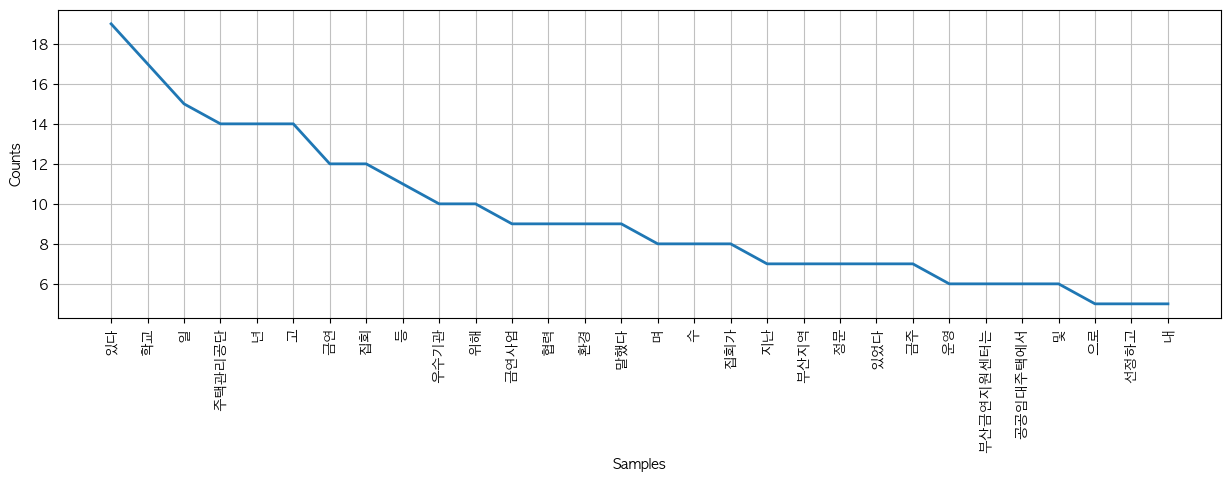

In [16]:
words = Text(words)
%matplotlib inline
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(15, 4))
words.plot(30)
plt.show()

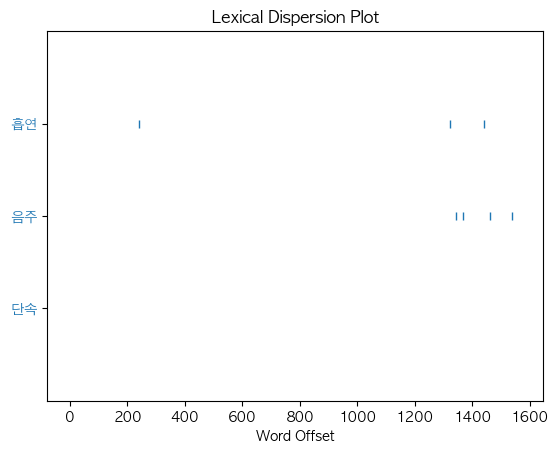

In [17]:
words.dispersion_plot(['흡연', '음주', '단속'])
plt.show()

# 한글 형태소 분석

In [18]:
text = ' '.join(words)

## Hannanum

In [19]:
hannanum = Hannanum(jvmpath=None, max_heap_size=1024)

In [20]:
hannanum.analyze(text)
# for word in words:
#     print(hannanum.analyze(word))

[[[('부산대학교', 'ncn'), ('병원', 'ncn'), ('에서', 'jca')],
  [('부산', 'ncps'), ('대학교', 'ncn'), ('병원', 'ncn'), ('에서', 'jca')]],
 [[('운영', 'ncpa')]],
 [[('중인', 'ncn')],
  [('중', 'nbn'), ('이', 'jp'), ('ㄴ', 'etm')],
  [('중', 'ncn'), ('이', 'jp'), ('ㄴ', 'etm')]],
 [[('부산', 'ncps'),
   ('금연', 'ncpa'),
   ('지원', 'ncpa'),
   ('센터', 'ncn'),
   ('가', 'jcc')],
  [('부산', 'ncps'),
   ('금연', 'ncpa'),
   ('지원', 'ncpa'),
   ('센터', 'ncn'),
   ('가', 'jcs')]],
 [[('지나', 'pvg'), ('ㄴ', 'etm')]],
 [[('일', 'nbu')],
  [('일', 'ncn')],
  [('일', 'ncpa')],
  [('일', 'ncps')],
  [('일', 'nnc')],
  [('일', 'pvg'), ('ㄹ', 'etm')],
  [('이', 'pvg'), ('ㄹ', 'etm')]],
 [[('주택관리', 'ncn'), ('공단', 'ncn')],
  [('주택', 'ncn'), ('관리공단', 'ncn')],
  [('주택', 'ncn'), ('관리', 'ncn'), ('공단', 'ncn')],
  [('주택', 'ncn'), ('관리', 'ncpa'), ('공단', 'ncn')]],
 [[('부산울산', 'ncn'), ('지사', 'ncr'), ('를', 'jco')],
  [('부산울산지사', 'ncn'), ('를', 'jco')],
  [('부산울산지사를', 'ncn')],
  [('부산울산', 'nqq'), ('지사', 'ncr'), ('를', 'jco')],
  [('부산울산지사', 'nqq'), ('를', 'jco')],
  

In [21]:
# 형태소 분석
hannanum.morphs(text)

['부산대학교병원',
 '에서',
 '운영',
 '중',
 '이',
 'ㄴ',
 '부산금연지원센터',
 '가',
 '지나',
 'ㄴ',
 '일',
 '주택관리공단',
 '부산울산지사',
 '를',
 '년',
 '금연사업',
 '협력',
 '우수기관',
 '으',
 '로',
 '선정',
 '하고',
 '현판식',
 '을',
 '개최',
 '하',
 '었다',
 '부산금연지원센터',
 '는',
 '지나',
 'ㄴ',
 '년',
 '주택관리공단',
 '부산울산지사',
 '와',
 '업무협약',
 '을',
 '체결',
 '하',
 'ㄴ',
 '이후',
 '부산지역',
 '내',
 '곳',
 '이상',
 '의',
 '공공임대주택',
 '에서',
 '금연',
 '환경',
 '조성',
 '과',
 '입주민',
 '건강증진',
 '을',
 '위하',
 'ㄴ',
 '다양한',
 '활동',
 '을',
 '잇',
 '어',
 '오',
 '고',
 '있',
 '다',
 '주택관리공단',
 '부산울산지사',
 '는',
 '부산지역',
 '공공임대주택',
 '에서',
 '생활터',
 '금연지원서비스',
 '적극',
 '추진',
 '입주민',
 '대상',
 '금연캠페인',
 '및',
 '금연상담',
 '프로그램',
 '운영',
 '공공임대주택',
 '내',
 '상습',
 '흡연구역',
 '개',
 '선',
 '지역사회',
 '와',
 '연계',
 '하',
 'ㄴ',
 '중독',
 '예방',
 '캠페인',
 '등',
 '활발',
 '하',
 'ㄴ',
 '활동',
 '으로',
 '이번',
 '연계',
 '우수',
 '기관',
 '에',
 '선정',
 '되',
 '었다',
 '왼쪽',
 '부터',
 '장성철',
 '주택관리공단부산울산지사장',
 '과',
 '이효영',
 '부산금연지원센터',
 '부장',
 '이',
 '년',
 '금연사업',
 '협력',
 '우수기관',
 '현판식',
 '에서',
 '기념촬영',
 '을',
 '하',
 '고',
 '있',
 '다',
 '사',
 '아',
 '지'

In [22]:
# 명사만 추출
hannanum.nouns(text)

['부산대학교병원',
 '운영',
 '중',
 '부산금연지원센터',
 '일',
 '주택관리공단',
 '부산울산지사',
 '년',
 '금연사업',
 '협력',
 '우수기관',
 '으',
 '선정',
 '현판식',
 '개최',
 '부산금연지원센터',
 '년',
 '주택관리공단',
 '부산울산지사',
 '업무협약',
 '체결',
 '이후',
 '부산지역',
 '내',
 '곳',
 '이상',
 '공공임대주택',
 '금연',
 '환경',
 '조성',
 '입주민',
 '건강증진',
 '다양한',
 '활동',
 '주택관리공단',
 '부산울산지사',
 '부산지역',
 '공공임대주택',
 '생활터',
 '금연지원서비스',
 '적극',
 '추진',
 '입주민',
 '대상',
 '금연캠페인',
 '금연상담',
 '프로그램',
 '운영',
 '공공임대주택',
 '내',
 '상습',
 '흡연구역',
 '개',
 '지역사회',
 '연계',
 '중독',
 '예방',
 '캠페인',
 '등',
 '활발',
 '활동',
 '이번',
 '연계',
 '우수',
 '기관',
 '선정',
 '왼쪽',
 '장성철',
 '주택관리공단부산울산지사장',
 '이효영',
 '부산금연지원센터',
 '부장',
 '년',
 '금연사업',
 '협력',
 '우수기관',
 '현판식',
 '기념촬영',
 '부산대학교병원',
 '이승훈',
 '부산금연지원센터장',
 '금연사업',
 '지역사회',
 '적극적',
 '연계',
 '협력',
 '무엇',
 '중요',
 '며',
 '이번',
 '우수기관',
 '선정',
 '입주민',
 '금연',
 '활동',
 '지역사회',
 '연계',
 '활성화',
 '긍정적',
 '영향',
 '것',
 '말',
 '장성철',
 '주택관리공단',
 '부산울산지사장',
 '금연사업',
 '협력',
 '우수기관',
 '선정',
 '것',
 '계기',
 '앞',
 '입주민',
 '지속',
 '가능',
 '금연',
 '환경',
 '조성',
 '며',
 '주거',
 '취약계층',
 '쾌적',
 '환경',
 

In [23]:
# 품사태그
hannanum.pos(text)

[('부산대학교병원', 'N'),
 ('에서', 'J'),
 ('운영', 'N'),
 ('중', 'N'),
 ('이', 'J'),
 ('ㄴ', 'E'),
 ('부산금연지원센터', 'N'),
 ('가', 'J'),
 ('지나', 'P'),
 ('ㄴ', 'E'),
 ('일', 'N'),
 ('주택관리공단', 'N'),
 ('부산울산지사', 'N'),
 ('를', 'J'),
 ('년', 'N'),
 ('금연사업', 'N'),
 ('협력', 'N'),
 ('우수기관', 'N'),
 ('으', 'N'),
 ('로', 'J'),
 ('선정', 'N'),
 ('하고', 'J'),
 ('현판식', 'N'),
 ('을', 'J'),
 ('개최', 'N'),
 ('하', 'X'),
 ('었다', 'E'),
 ('부산금연지원센터', 'N'),
 ('는', 'J'),
 ('지나', 'P'),
 ('ㄴ', 'E'),
 ('년', 'N'),
 ('주택관리공단', 'N'),
 ('부산울산지사', 'N'),
 ('와', 'J'),
 ('업무협약', 'N'),
 ('을', 'J'),
 ('체결', 'N'),
 ('하', 'X'),
 ('ㄴ', 'E'),
 ('이후', 'N'),
 ('부산지역', 'N'),
 ('내', 'N'),
 ('곳', 'N'),
 ('이상', 'N'),
 ('의', 'J'),
 ('공공임대주택', 'N'),
 ('에서', 'J'),
 ('금연', 'N'),
 ('환경', 'N'),
 ('조성', 'N'),
 ('과', 'J'),
 ('입주민', 'N'),
 ('건강증진', 'N'),
 ('을', 'J'),
 ('위하', 'P'),
 ('ㄴ', 'E'),
 ('다양한', 'N'),
 ('활동', 'N'),
 ('을', 'J'),
 ('잇', 'P'),
 ('어', 'E'),
 ('오', 'P'),
 ('고', 'E'),
 ('있', 'P'),
 ('다', 'E'),
 ('주택관리공단', 'N'),
 ('부산울산지사', 'N'),
 ('는', 'J'),
 ('부산지역',

In [24]:
hannanum.pos(text, ntags=22)

[('부산대학교병원', 'NC'),
 ('에서', 'JC'),
 ('운영', 'NC'),
 ('중', 'NB'),
 ('이', 'JP'),
 ('ㄴ', 'ET'),
 ('부산금연지원센터', 'NC'),
 ('가', 'JC'),
 ('지나', 'PV'),
 ('ㄴ', 'ET'),
 ('일', 'NN'),
 ('주택관리공단', 'NC'),
 ('부산울산지사', 'NC'),
 ('를', 'JC'),
 ('년', 'NB'),
 ('금연사업', 'NC'),
 ('협력', 'NC'),
 ('우수기관', 'NC'),
 ('으', 'NC'),
 ('로', 'JC'),
 ('선정', 'NC'),
 ('하고', 'JC'),
 ('현판식', 'NC'),
 ('을', 'JC'),
 ('개최', 'NC'),
 ('하', 'XS'),
 ('었', 'EP'),
 ('다', 'EF'),
 ('부산금연지원센터', 'NC'),
 ('는', 'JX'),
 ('지나', 'PV'),
 ('ㄴ', 'ET'),
 ('년', 'NB'),
 ('주택관리공단', 'NC'),
 ('부산울산지사', 'NC'),
 ('와', 'JC'),
 ('업무협약', 'NC'),
 ('을', 'JC'),
 ('체결', 'NC'),
 ('하', 'XS'),
 ('ㄴ', 'ET'),
 ('이후', 'NC'),
 ('부산지역', 'NC'),
 ('내', 'NP'),
 ('곳', 'NC'),
 ('이상', 'NC'),
 ('의', 'JC'),
 ('공공임대주택', 'NC'),
 ('에서', 'JC'),
 ('금연', 'NC'),
 ('환경', 'NC'),
 ('조성', 'NC'),
 ('과', 'JC'),
 ('입주민', 'NC'),
 ('건강증진', 'NC'),
 ('을', 'JC'),
 ('위하', 'PV'),
 ('ㄴ', 'ET'),
 ('다양한', 'NC'),
 ('활동', 'NC'),
 ('을', 'JC'),
 ('잇', 'PV'),
 ('어', 'EC'),
 ('오', 'PX'),
 ('고', 'EC'),
 ('있', 

In [25]:
# 보통명사(NC)만 추출
hannanum_tagged_text = hannanum.pos(text, ntags=22)
[word for word, tag in hannanum_tagged_text if tag == 'NC']

['부산대학교병원',
 '운영',
 '부산금연지원센터',
 '주택관리공단',
 '부산울산지사',
 '금연사업',
 '협력',
 '우수기관',
 '으',
 '선정',
 '현판식',
 '개최',
 '부산금연지원센터',
 '주택관리공단',
 '부산울산지사',
 '업무협약',
 '체결',
 '이후',
 '부산지역',
 '곳',
 '이상',
 '공공임대주택',
 '금연',
 '환경',
 '조성',
 '입주민',
 '건강증진',
 '다양한',
 '활동',
 '주택관리공단',
 '부산울산지사',
 '부산지역',
 '공공임대주택',
 '생활터',
 '금연지원서비스',
 '적극',
 '추진',
 '입주민',
 '대상',
 '금연캠페인',
 '금연상담',
 '프로그램',
 '운영',
 '공공임대주택',
 '상습',
 '흡연구역',
 '지역사회',
 '연계',
 '중독',
 '예방',
 '캠페인',
 '활발',
 '활동',
 '연계',
 '우수',
 '기관',
 '선정',
 '왼쪽',
 '장성철',
 '주택관리공단부산울산지사장',
 '이효영',
 '부산금연지원센터',
 '부장',
 '금연사업',
 '협력',
 '우수기관',
 '현판식',
 '기념촬영',
 '부산대학교병원',
 '이승훈',
 '부산금연지원센터장',
 '금연사업',
 '지역사회',
 '적극적',
 '연계',
 '협력',
 '중요',
 '며',
 '우수기관',
 '선정',
 '입주민',
 '금연',
 '활동',
 '지역사회',
 '연계',
 '활성화',
 '긍정적',
 '영향',
 '말',
 '장성철',
 '주택관리공단',
 '부산울산지사장',
 '금연사업',
 '협력',
 '우수기관',
 '선정',
 '계기',
 '앞',
 '입주민',
 '지속',
 '가능',
 '금연',
 '환경',
 '조성',
 '며',
 '주거',
 '취약계층',
 '쾌적',
 '환경',
 '생활',
 '지원',
 '말',
 '합천',
 '뉴시스',
 '합천군청',
 '합천보건소',
 '금연클리닉',
 '재판매',
 '금지',
 '재판매',
 

## Kkma

In [26]:
kkma = Kkma()

In [27]:
# 형태소 분석
kkma.morphs(text)

['부산',
 '대학교',
 '병원',
 '에서',
 '운영',
 '중인',
 '부산',
 '금연',
 '지원',
 '센터',
 '가',
 '지나',
 'ㄴ',
 '일',
 '주택',
 '관리',
 '공단',
 '부산',
 '울산',
 '지사',
 '를',
 '녀',
 'ㄴ',
 '금연',
 '사업',
 '협력',
 '우수',
 '기관',
 '으로',
 '선정',
 '하',
 '고',
 '현판식',
 '을',
 '개최',
 '하',
 '었',
 '다',
 '부산',
 '금연',
 '지원',
 '센터',
 '는',
 '지나',
 'ㄴ',
 '년',
 '주택',
 '관리',
 '공단',
 '부산',
 '울산',
 '지사',
 '와',
 '업무',
 '협약',
 '을',
 '체결',
 '하',
 'ㄴ',
 '이후',
 '부산',
 '지역',
 '내',
 '곳',
 '이상',
 '의',
 '공공',
 '임대',
 '주택',
 '에서',
 '금연',
 '환경',
 '조성',
 '과',
 '입주민',
 '건강',
 '증진',
 '을',
 '위하',
 'ㄴ',
 '다양',
 '하',
 'ㄴ',
 '활동',
 '을',
 '잇',
 '어',
 '오',
 '고',
 '있',
 '다',
 '주택',
 '관리',
 '공단',
 '부산',
 '울산',
 '지사',
 '는',
 '부산',
 '지역',
 '공공',
 '임대',
 '주택',
 '에서',
 '생활',
 '트',
 '어',
 '금연',
 '지원',
 '서비스',
 '적극',
 '추진',
 '입주민',
 '대상',
 '금연',
 '캠페인',
 '및',
 '금연',
 '상담',
 '프로그램',
 '운영',
 '공공',
 '임대',
 '주택',
 '내',
 '상습',
 '흡연',
 '구역',
 '개선',
 '지역',
 '사회',
 '와',
 '연계',
 '하',
 'ㄴ',
 '중독',
 '예방',
 '캠페인',
 '등',
 '활발',
 '하',
 'ㄴ',
 '활동',
 '으로',
 '이번',
 '연계',
 '우수',
 '기관',


In [28]:
# 명사만 추출
kkma.nouns(text)

['부산',
 '부산대학교병원',
 '대학교',
 '병원',
 '운영',
 '중인',
 '부산금연지원센터',
 '금연',
 '지원',
 '센터',
 '일',
 '주택',
 '주택관리공단',
 '관리',
 '공단',
 '부산울산지사',
 '울산',
 '지사',
 '금연사업',
 '사업',
 '협력',
 '우수',
 '우수기관',
 '기관',
 '선정',
 '현판식',
 '개최',
 '년',
 '업무',
 '업무협약',
 '협약',
 '체결',
 '이후',
 '부산지역',
 '지역',
 '내',
 '곳',
 '이상',
 '공공',
 '공공임대주택',
 '임대',
 '환경',
 '조성',
 '입주민',
 '건강',
 '건강증진',
 '증진',
 '다양',
 '활동',
 '생활',
 '금연지원서비스',
 '서비스',
 '적극',
 '추진',
 '대상',
 '금연캠페인',
 '캠페인',
 '금연상담',
 '상담',
 '프로그램',
 '상습',
 '흡연',
 '흡연구역',
 '구역',
 '개선',
 '지역사회',
 '사회',
 '연계',
 '중독',
 '예방',
 '등',
 '이번',
 '왼쪽',
 '장',
 '장성철',
 '성철',
 '주택관리공단부산',
 '울산지사장',
 '지사장',
 '효',
 '효영',
 '영',
 '부',
 '기념',
 '기념촬영',
 '촬영',
 '사진',
 '이승훈',
 '적극적',
 '무엇',
 '중요',
 '활성화',
 '긍정적',
 '영향',
 '기대',
 '부산울산지사장',
 '계기',
 '앞',
 '지속',
 '가능',
 '며',
 '주거',
 '취약',
 '취약계층',
 '계층',
 '수',
 '고',
 '합',
 '뉴',
 '뉴시스',
 '시스',
 '합천',
 '합천군',
 '군',
 '합천보건소',
 '천',
 '보건소',
 '금연클리닉',
 '클리닉',
 '재판매',
 '금지',
 '희원',
 '기자',
 '경남',
 '성인',
 '남성',
 '흡연율',
 '지난해',
 '포인트',
 '감소',
 '를',
 '기록',
 '

In [29]:
# 품사태그
kkma.pos(text)

[('부산', 'NNG'),
 ('대학교', 'NNG'),
 ('병원', 'NNG'),
 ('에서', 'JKM'),
 ('운영', 'NNG'),
 ('중인', 'NNG'),
 ('부산', 'NNG'),
 ('금연', 'NNG'),
 ('지원', 'NNG'),
 ('센터', 'NNG'),
 ('가', 'JKS'),
 ('지나', 'VV'),
 ('ㄴ', 'ETD'),
 ('일', 'NNG'),
 ('주택', 'NNG'),
 ('관리', 'NNG'),
 ('공단', 'NNG'),
 ('부산', 'NNG'),
 ('울산', 'NNG'),
 ('지사', 'NNG'),
 ('를', 'JKO'),
 ('녀', 'VV'),
 ('ㄴ', 'ETD'),
 ('금연', 'NNG'),
 ('사업', 'NNG'),
 ('협력', 'NNG'),
 ('우수', 'NNG'),
 ('기관', 'NNG'),
 ('으로', 'JKM'),
 ('선정', 'NNG'),
 ('하', 'XSV'),
 ('고', 'ECE'),
 ('현판식', 'NNG'),
 ('을', 'JKO'),
 ('개최', 'NNG'),
 ('하', 'XSV'),
 ('었', 'EPT'),
 ('다', 'ECS'),
 ('부산', 'NNG'),
 ('금연', 'NNG'),
 ('지원', 'NNG'),
 ('센터', 'NNG'),
 ('는', 'JX'),
 ('지나', 'VV'),
 ('ㄴ', 'ETD'),
 ('년', 'NNB'),
 ('주택', 'NNG'),
 ('관리', 'NNG'),
 ('공단', 'NNG'),
 ('부산', 'NNG'),
 ('울산', 'NNG'),
 ('지사', 'NNG'),
 ('와', 'JC'),
 ('업무', 'NNG'),
 ('협약', 'NNG'),
 ('을', 'JKO'),
 ('체결', 'NNG'),
 ('하', 'XSV'),
 ('ㄴ', 'ETD'),
 ('이후', 'NNG'),
 ('부산', 'NNG'),
 ('지역', 'NNG'),
 ('내', 'NNB'),
 ('곳', 'NNG'),


In [30]:
# 보통명사(NNG), 고유명사(NNP)만 추출
kkma_tagged_text = kkma.pos(text)
[word for word, tag in kkma_tagged_text if (tag == 'NNG') + (tag == 'NNP')]

['부산',
 '대학교',
 '병원',
 '운영',
 '중인',
 '부산',
 '금연',
 '지원',
 '센터',
 '일',
 '주택',
 '관리',
 '공단',
 '부산',
 '울산',
 '지사',
 '금연',
 '사업',
 '협력',
 '우수',
 '기관',
 '선정',
 '현판식',
 '개최',
 '부산',
 '금연',
 '지원',
 '센터',
 '주택',
 '관리',
 '공단',
 '부산',
 '울산',
 '지사',
 '업무',
 '협약',
 '체결',
 '이후',
 '부산',
 '지역',
 '곳',
 '이상',
 '공공',
 '임대',
 '주택',
 '금연',
 '환경',
 '조성',
 '입주민',
 '건강',
 '증진',
 '다양',
 '활동',
 '주택',
 '관리',
 '공단',
 '부산',
 '울산',
 '지사',
 '부산',
 '지역',
 '공공',
 '임대',
 '주택',
 '생활',
 '금연',
 '지원',
 '서비스',
 '적극',
 '추진',
 '입주민',
 '대상',
 '금연',
 '캠페인',
 '금연',
 '상담',
 '프로그램',
 '운영',
 '공공',
 '임대',
 '주택',
 '상습',
 '흡연',
 '구역',
 '개선',
 '지역',
 '사회',
 '연계',
 '중독',
 '예방',
 '캠페인',
 '활동',
 '이번',
 '연계',
 '우수',
 '기관',
 '선정',
 '왼쪽',
 '장',
 '성철',
 '주택',
 '관리',
 '공단',
 '부산',
 '울산',
 '지사장',
 '효',
 '영',
 '부산',
 '금연',
 '지원',
 '센터',
 '부',
 '금연',
 '사업',
 '협력',
 '우수',
 '기관',
 '현판식',
 '기념',
 '촬영',
 '사진',
 '부산',
 '대학교',
 '병원',
 '이승훈',
 '부산',
 '금연',
 '지원',
 '센터',
 '장',
 '금연',
 '사업',
 '지역',
 '사회',
 '적극적',
 '연계',
 '협력',
 '중요',
 '이번',
 '우수',
 '기관',

## Komoran

In [31]:
komoran = Komoran()

In [32]:
# 형태소 분석
komoran.morphs(text)

['부산대학교병원',
 '에서',
 '운영',
 '중',
 '이',
 'ㄴ',
 '부산',
 '금연',
 '지원',
 '센터',
 '가',
 '지나',
 'ㄴ',
 '일',
 '주택관리공단',
 '부산',
 '울산',
 '지사',
 '를',
 '년',
 '금연',
 '사업',
 '협력',
 '우수',
 '기관',
 '으로',
 '선정',
 '하',
 '고',
 '현판식',
 '을',
 '개최',
 '하',
 '았',
 '다',
 '부산',
 '금연',
 '지원',
 '센터',
 '는',
 '지나',
 'ㄴ',
 '년',
 '주택관리공단',
 '부산',
 '울산',
 '지사',
 '와',
 '업무',
 '협약',
 '을',
 '체결',
 '하',
 'ㄴ',
 '이후',
 '부산',
 '지역',
 '내',
 '곳',
 '이상',
 '의',
 '공공',
 '임대',
 '주택',
 '에서',
 '금연',
 '환경',
 '조성',
 '과',
 '입주민',
 '건강증진',
 '을',
 '위하',
 'ㄴ',
 '다양',
 '하',
 'ㄴ',
 '활동',
 '을',
 '잇',
 '어',
 '오',
 '고',
 '있',
 '다',
 '주택관리공단',
 '부산',
 '울산',
 '지사',
 '는',
 '부산',
 '지역',
 '공공',
 '임대',
 '주택',
 '에서',
 '생활',
 '터',
 '금연',
 '지원',
 '서비스',
 '적극',
 '추진',
 '입주민',
 '대상',
 '금연',
 '캠페인',
 '및',
 '금연',
 '상담',
 '프로그램',
 '운영',
 '공공',
 '임대',
 '주택',
 '내',
 '상습',
 '흡연',
 '구역',
 '개선',
 '지역',
 '사회',
 '와',
 '연계',
 '하',
 'ㄴ',
 '중독',
 '예방',
 '캠페인',
 '등',
 '활발',
 '하',
 'ㄴ',
 '활동',
 '으로',
 '이번',
 '연계',
 '우수',
 '기관',
 '에',
 '선정',
 '되',
 '었',
 '다',
 '왼쪽',
 '부터',
 

In [33]:
# 명사만 추출
komoran.nouns(text)

['부산대학교병원',
 '운영',
 '중',
 '부산',
 '금연',
 '지원',
 '센터',
 '일',
 '주택관리공단',
 '부산',
 '울산',
 '지사',
 '년',
 '금연',
 '사업',
 '협력',
 '우수',
 '기관',
 '선정',
 '현판식',
 '개최',
 '부산',
 '금연',
 '지원',
 '센터',
 '년',
 '주택관리공단',
 '부산',
 '울산',
 '지사',
 '업무',
 '협약',
 '체결',
 '이후',
 '부산',
 '지역',
 '곳',
 '이상',
 '공공',
 '임대',
 '주택',
 '금연',
 '환경',
 '조성',
 '입주민',
 '건강증진',
 '활동',
 '주택관리공단',
 '부산',
 '울산',
 '지사',
 '부산',
 '지역',
 '공공',
 '임대',
 '주택',
 '생활',
 '터',
 '금연',
 '지원',
 '서비스',
 '적극',
 '추진',
 '입주민',
 '대상',
 '금연',
 '캠페인',
 '금연',
 '상담',
 '프로그램',
 '운영',
 '공공',
 '임대',
 '주택',
 '상습',
 '흡연',
 '구역',
 '개선',
 '지역',
 '사회',
 '연계',
 '중독',
 '예방',
 '캠페인',
 '등',
 '활동',
 '이번',
 '연계',
 '우수',
 '기관',
 '선정',
 '왼쪽',
 '장',
 '성철',
 '주택관리공단',
 '부산',
 '울산',
 '지사',
 '장과',
 '이효영',
 '부산',
 '금연',
 '지원',
 '센터',
 '부장',
 '년',
 '금연',
 '사업',
 '협력',
 '우수',
 '기관',
 '현판식',
 '기념',
 '촬영',
 '사진',
 '부산대학교병원',
 '이승훈',
 '부산',
 '금연',
 '지원',
 '센터',
 '장',
 '금연',
 '사업',
 '지역',
 '사회',
 '적극',
 '연계',
 '협력',
 '이번',
 '우수',
 '기관',
 '선정',
 '입주민',
 '금연',
 '활동',
 '지역',
 '사회',
 '연계

In [34]:
# 품사태그
komoran.pos(text)

[('부산대학교병원', 'NNP'),
 ('에서', 'JKB'),
 ('운영', 'NNG'),
 ('중', 'NNB'),
 ('이', 'VCP'),
 ('ㄴ', 'ETM'),
 ('부산', 'NNP'),
 ('금연', 'NNP'),
 ('지원', 'NNP'),
 ('센터', 'NNP'),
 ('가', 'JKS'),
 ('지나', 'VV'),
 ('ㄴ', 'ETM'),
 ('일', 'NNB'),
 ('주택관리공단', 'NNP'),
 ('부산', 'NNP'),
 ('울산', 'NNP'),
 ('지사', 'NNP'),
 ('를', 'JKO'),
 ('년', 'NNB'),
 ('금연', 'NNP'),
 ('사업', 'NNP'),
 ('협력', 'NNG'),
 ('우수', 'NNP'),
 ('기관', 'NNP'),
 ('으로', 'JKB'),
 ('선정', 'NNG'),
 ('하', 'XSV'),
 ('고', 'EC'),
 ('현판식', 'NNG'),
 ('을', 'JKO'),
 ('개최', 'NNG'),
 ('하', 'XSV'),
 ('았', 'EP'),
 ('다', 'EC'),
 ('부산', 'NNP'),
 ('금연', 'NNP'),
 ('지원', 'NNP'),
 ('센터', 'NNP'),
 ('는', 'JX'),
 ('지나', 'VV'),
 ('ㄴ', 'ETM'),
 ('년', 'NNB'),
 ('주택관리공단', 'NNP'),
 ('부산', 'NNP'),
 ('울산', 'NNP'),
 ('지사', 'NNP'),
 ('와', 'JC'),
 ('업무', 'NNG'),
 ('협약', 'NNG'),
 ('을', 'JKO'),
 ('체결', 'NNG'),
 ('하', 'XSV'),
 ('ㄴ', 'ETM'),
 ('이후', 'NNG'),
 ('부산', 'NNP'),
 ('지역', 'NNP'),
 ('내', 'NP'),
 ('곳', 'NNG'),
 ('이상', 'NNG'),
 ('의', 'JKG'),
 ('공공', 'NNP'),
 ('임대', 'NNP'),
 ('주택', 'N

In [35]:
# 일반명사(NNG), 고유명사(NNP)만 추출
komoran_tagged_text = komoran.pos(text)
[word for word, tag in komoran_tagged_text if tag in ('NNG', 'NNP')]

['부산대학교병원',
 '운영',
 '부산',
 '금연',
 '지원',
 '센터',
 '주택관리공단',
 '부산',
 '울산',
 '지사',
 '금연',
 '사업',
 '협력',
 '우수',
 '기관',
 '선정',
 '현판식',
 '개최',
 '부산',
 '금연',
 '지원',
 '센터',
 '주택관리공단',
 '부산',
 '울산',
 '지사',
 '업무',
 '협약',
 '체결',
 '이후',
 '부산',
 '지역',
 '곳',
 '이상',
 '공공',
 '임대',
 '주택',
 '금연',
 '환경',
 '조성',
 '입주민',
 '건강증진',
 '활동',
 '주택관리공단',
 '부산',
 '울산',
 '지사',
 '부산',
 '지역',
 '공공',
 '임대',
 '주택',
 '생활',
 '금연',
 '지원',
 '서비스',
 '적극',
 '추진',
 '입주민',
 '대상',
 '금연',
 '캠페인',
 '금연',
 '상담',
 '프로그램',
 '운영',
 '공공',
 '임대',
 '주택',
 '상습',
 '흡연',
 '구역',
 '개선',
 '지역',
 '사회',
 '연계',
 '중독',
 '예방',
 '캠페인',
 '활동',
 '이번',
 '연계',
 '우수',
 '기관',
 '선정',
 '왼쪽',
 '장',
 '성철',
 '주택관리공단',
 '부산',
 '울산',
 '지사',
 '장과',
 '이효영',
 '부산',
 '금연',
 '지원',
 '센터',
 '부장',
 '금연',
 '사업',
 '협력',
 '우수',
 '기관',
 '현판식',
 '기념',
 '촬영',
 '사진',
 '부산대학교병원',
 '이승훈',
 '부산',
 '금연',
 '지원',
 '센터',
 '장',
 '금연',
 '사업',
 '지역',
 '사회',
 '적극',
 '연계',
 '협력',
 '이번',
 '우수',
 '기관',
 '선정',
 '입주민',
 '금연',
 '활동',
 '지역',
 '사회',
 '연계',
 '활성',
 '긍정',
 '영향',
 '기대',
 '말',
 '장',

## Twitter, Okt

In [36]:
twitter = Okt()

In [37]:
# 구 추출
twitter.phrases(text)

['부산대학교병원',
 '운영',
 '운영 중인',
 '운영 중인 부산금연',
 '원센터',
 '지난',
 '지난 일',
 '지난 일 주택관리공단',
 '지난 일 주택관리공단 부산울산지사',
 '년 금연사업',
 '년 금연사업 협력',
 '년 금연사업 협력 우수기관',
 '선정',
 '현판식',
 '개최',
 '부산금연',
 '지난 년',
 '지난 년 주택관리공단',
 '지난 년 주택관리공단 부산울산지사',
 '지난 년 주택관리공단 부산울산지사와 업무협약',
 '체결',
 '이후',
 '이후 부산지역',
 '이후 부산지역 내',
 '이후 부산지역 내 곳',
 '이후 부산지역 내 곳 이상',
 '이후 부산지역 내 곳 이상의 공공임대주택',
 '금연',
 '금연 환경',
 '금연 환경 조성',
 '금연 환경 조성과 입주민',
 '금연 환경 조성과 입주민 건강증진',
 '다양한 활동',
 '주택관리공단',
 '주택관리공단 부산울산지사',
 '부산지역',
 '부산지역 공공임대주택',
 '생활터',
 '생활터 금연지원서비스',
 '생활터 금연지원서비스 적극',
 '생활터 금연지원서비스 적극 추진',
 '생활터 금연지원서비스 적극 추진 입주민',
 '생활터 금연지원서비스 적극 추진 입주민 대상',
 '생활터 금연지원서비스 적극 추진 입주민 대상 금연캠페인',
 '생활터 금연지원서비스 적극 추진 입주민 대상 금연캠페인 및',
 '중독',
 '중독 예방',
 '중독 예방 캠페인',
 '중독 예방 캠페인 등',
 '중독 예방 캠페인 등 활발한 활동',
 '이번',
 '이번 연계',
 '이번 연계 우수',
 '이번 연계 우수 기관',
 '왼쪽',
 '장성철',
 '장성철 주택관리공단부산울산',
 '사장',
 '사장과 이효영',
 '사장과 이효영 부산금연지원센터',
 '사장과 이효영 부산금연지원센터 부장',
 '년 금연사업 협력 우수기관 현판식',
 '기념촬영',
 '사진',
 '사진 부산대학교병원',
 '사진 부산대학교병원 이승훈',
 '사진 부산대학교병원 이승훈 부산금연',


In [38]:
# 형태소 분석
twitter.morphs(text)

['부산대학교',
 '병원',
 '에서',
 '운영',
 '중인',
 '부산',
 '금연',
 '지',
 '원',
 '센터',
 '가',
 '지난',
 '일',
 '주택',
 '관리',
 '공단',
 '부산',
 '울산',
 '지사',
 '를',
 '년',
 '금연',
 '사업',
 '협력',
 '우수',
 '기관',
 '으로',
 '선정',
 '하고',
 '현판',
 '식',
 '을',
 '개최',
 '했다',
 '부산',
 '금연',
 '지',
 '원',
 '센터',
 '는',
 '지난',
 '년',
 '주택',
 '관리',
 '공단',
 '부산',
 '울산',
 '지사',
 '와',
 '업무',
 '협약',
 '을',
 '체결',
 '한',
 '이후',
 '부산',
 '지역',
 '내',
 '곳',
 '이상',
 '의',
 '공공',
 '임대주택',
 '에서',
 '금연',
 '환경',
 '조성',
 '과',
 '입',
 '주민',
 '건강',
 '증진',
 '을',
 '위',
 '한',
 '다양한',
 '활동',
 '을',
 '이어오고',
 '있다',
 '주택',
 '관리',
 '공단',
 '부산',
 '울산',
 '지사',
 '는',
 '부산',
 '지역',
 '공공',
 '임대주택',
 '에서',
 '생활',
 '터',
 '금연',
 '지원',
 '서비스',
 '적극',
 '추진',
 '입',
 '주민',
 '대상',
 '금연',
 '캠페인',
 '및',
 '금연',
 '상담',
 '프로그램',
 '운영',
 '공공',
 '임대주택',
 '내',
 '상습',
 '흡연',
 '구역',
 '개선',
 '지역',
 '사회',
 '와',
 '연',
 '계',
 '한',
 '중독',
 '예방',
 '캠페인',
 '등',
 '활발한',
 '활동',
 '으로',
 '이번',
 '연',
 '계',
 '우수',
 '기관',
 '에',
 '선정',
 '됐다',
 '왼쪽',
 '부터',
 '장성',
 '철',
 '주택',
 '관리',
 '공',
 '단',
 '부산',


In [39]:
# 명사만 추출
twitter.nouns(text)

['부산대학교',
 '병원',
 '운영',
 '중인',
 '부산',
 '금연',
 '센터',
 '지난',
 '일',
 '주택',
 '관리',
 '공단',
 '부산',
 '울산',
 '지사',
 '년',
 '금연',
 '사업',
 '협력',
 '우수',
 '기관',
 '선정',
 '현판',
 '개최',
 '부산',
 '금연',
 '센터',
 '지난',
 '년',
 '주택',
 '관리',
 '공단',
 '부산',
 '울산',
 '지사',
 '업무',
 '협약',
 '체결',
 '이후',
 '부산',
 '지역',
 '내',
 '곳',
 '이상',
 '임대주택',
 '금연',
 '환경',
 '조성',
 '입',
 '주민',
 '건강',
 '증진',
 '위',
 '활동',
 '주택',
 '관리',
 '공단',
 '부산',
 '울산',
 '지사',
 '부산',
 '지역',
 '임대주택',
 '생활',
 '터',
 '금연',
 '지원',
 '서비스',
 '적극',
 '추진',
 '입',
 '주민',
 '대상',
 '금연',
 '캠페인',
 '및',
 '금연',
 '상담',
 '프로그램',
 '운영',
 '임대주택',
 '내',
 '상습',
 '흡연',
 '구역',
 '개선',
 '지역',
 '사회',
 '계',
 '중독',
 '예방',
 '캠페인',
 '등',
 '활동',
 '이번',
 '계',
 '우수',
 '기관',
 '선정',
 '왼쪽',
 '장성',
 '철',
 '주택',
 '관리',
 '부산',
 '울산',
 '사장',
 '이효영',
 '부산',
 '금연',
 '지원',
 '센터',
 '부장',
 '년',
 '금연',
 '사업',
 '협력',
 '우수',
 '기관',
 '현판',
 '기념',
 '촬영',
 '사진',
 '부산대학교',
 '병원',
 '이승훈',
 '부산',
 '금연',
 '센터',
 '금연',
 '사업',
 '지역',
 '사회',
 '적극',
 '계',
 '협력',
 '무엇',
 '며',
 '이번',
 '우수',
 '기관',
 '선정',
 '입',

In [40]:
# 품사태그
twitter.pos(text)

[('부산대학교', 'Noun'),
 ('병원', 'Noun'),
 ('에서', 'Josa'),
 ('운영', 'Noun'),
 ('중인', 'Noun'),
 ('부산', 'Noun'),
 ('금연', 'Noun'),
 ('지', 'Josa'),
 ('원', 'Modifier'),
 ('센터', 'Noun'),
 ('가', 'Josa'),
 ('지난', 'Noun'),
 ('일', 'Noun'),
 ('주택', 'Noun'),
 ('관리', 'Noun'),
 ('공단', 'Noun'),
 ('부산', 'Noun'),
 ('울산', 'Noun'),
 ('지사', 'Noun'),
 ('를', 'Josa'),
 ('년', 'Noun'),
 ('금연', 'Noun'),
 ('사업', 'Noun'),
 ('협력', 'Noun'),
 ('우수', 'Noun'),
 ('기관', 'Noun'),
 ('으로', 'Josa'),
 ('선정', 'Noun'),
 ('하고', 'Josa'),
 ('현판', 'Noun'),
 ('식', 'Suffix'),
 ('을', 'Josa'),
 ('개최', 'Noun'),
 ('했다', 'Verb'),
 ('부산', 'Noun'),
 ('금연', 'Noun'),
 ('지', 'Josa'),
 ('원', 'Modifier'),
 ('센터', 'Noun'),
 ('는', 'Josa'),
 ('지난', 'Noun'),
 ('년', 'Noun'),
 ('주택', 'Noun'),
 ('관리', 'Noun'),
 ('공단', 'Noun'),
 ('부산', 'Noun'),
 ('울산', 'Noun'),
 ('지사', 'Noun'),
 ('와', 'Josa'),
 ('업무', 'Noun'),
 ('협약', 'Noun'),
 ('을', 'Josa'),
 ('체결', 'Noun'),
 ('한', 'Josa'),
 ('이후', 'Noun'),
 ('부산', 'Noun'),
 ('지역', 'Noun'),
 ('내', 'Noun'),
 ('곳', 'Noun'),
 

In [41]:
twitter_tagged_text = twitter.pos(text)
[word for word, tag in twitter_tagged_text if tag == 'Noun']

['부산대학교',
 '병원',
 '운영',
 '중인',
 '부산',
 '금연',
 '센터',
 '지난',
 '일',
 '주택',
 '관리',
 '공단',
 '부산',
 '울산',
 '지사',
 '년',
 '금연',
 '사업',
 '협력',
 '우수',
 '기관',
 '선정',
 '현판',
 '개최',
 '부산',
 '금연',
 '센터',
 '지난',
 '년',
 '주택',
 '관리',
 '공단',
 '부산',
 '울산',
 '지사',
 '업무',
 '협약',
 '체결',
 '이후',
 '부산',
 '지역',
 '내',
 '곳',
 '이상',
 '임대주택',
 '금연',
 '환경',
 '조성',
 '입',
 '주민',
 '건강',
 '증진',
 '위',
 '활동',
 '주택',
 '관리',
 '공단',
 '부산',
 '울산',
 '지사',
 '부산',
 '지역',
 '임대주택',
 '생활',
 '터',
 '금연',
 '지원',
 '서비스',
 '적극',
 '추진',
 '입',
 '주민',
 '대상',
 '금연',
 '캠페인',
 '및',
 '금연',
 '상담',
 '프로그램',
 '운영',
 '임대주택',
 '내',
 '상습',
 '흡연',
 '구역',
 '개선',
 '지역',
 '사회',
 '계',
 '중독',
 '예방',
 '캠페인',
 '등',
 '활동',
 '이번',
 '계',
 '우수',
 '기관',
 '선정',
 '왼쪽',
 '장성',
 '철',
 '주택',
 '관리',
 '부산',
 '울산',
 '사장',
 '이효영',
 '부산',
 '금연',
 '지원',
 '센터',
 '부장',
 '년',
 '금연',
 '사업',
 '협력',
 '우수',
 '기관',
 '현판',
 '기념',
 '촬영',
 '사진',
 '부산대학교',
 '병원',
 '이승훈',
 '부산',
 '금연',
 '센터',
 '금연',
 '사업',
 '지역',
 '사회',
 '적극',
 '계',
 '협력',
 '무엇',
 '며',
 '이번',
 '우수',
 '기관',
 '선정',
 '입',

# 워드 클라우드

In [42]:
fontpath = '/System/Library/Fonts/Supplemental/AppleGothic.ttf'

In [43]:
word_list = [word for word, tag in kkma_tagged_text if tag in ('NNG', 'NNP')]
data_noun = ' '.join(word_list)

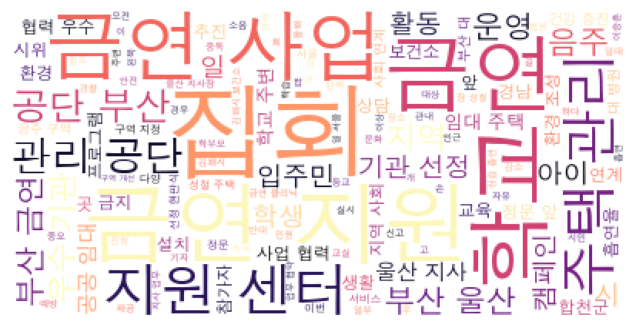

In [44]:
wordc = WordCloud(
            background_color='white',
            max_words=400,
            relative_scaling=0.3,
            colormap='magma',
            font_path=fontpath
)
# word = ' '.join(text)
wordc.generate(data_noun)
plt.figure(figsize=(10, 4))
plt.imshow(wordc)
plt.axis('off')
plt.show()

In [45]:
import nltk
import matplotlib.pyplot as plt
from konlpy.corpus import kolaw

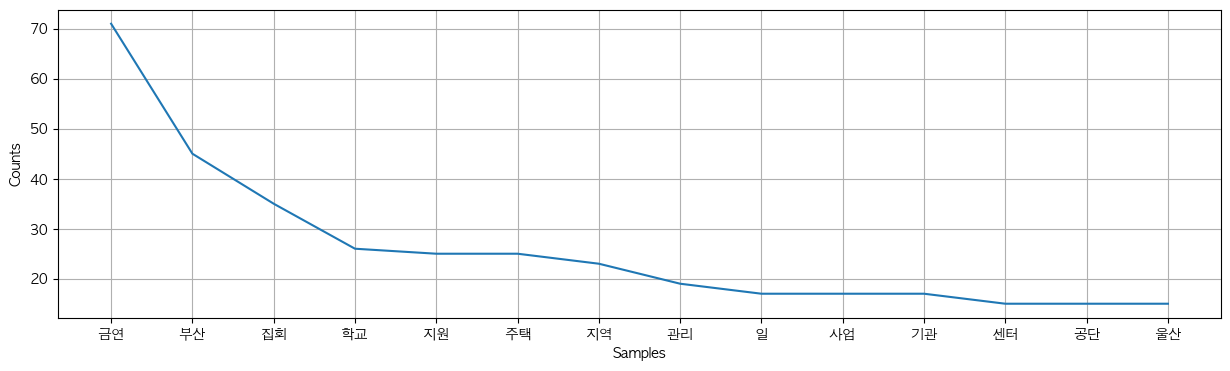

In [46]:
word_list = [word for word, tag in kkma_tagged_text if tag in ('NNG', 'NNP')]
data_text = nltk.Text(word_list)
words, counts = zip(*data_text.vocab().most_common(14))
plt.figure(figsize=(15, 4))
plt.plot(words, counts)
plt.xticks(rotation=0)
plt.xlabel('Samples')
plt.ylabel('Counts')
plt.grid()
plt.show()

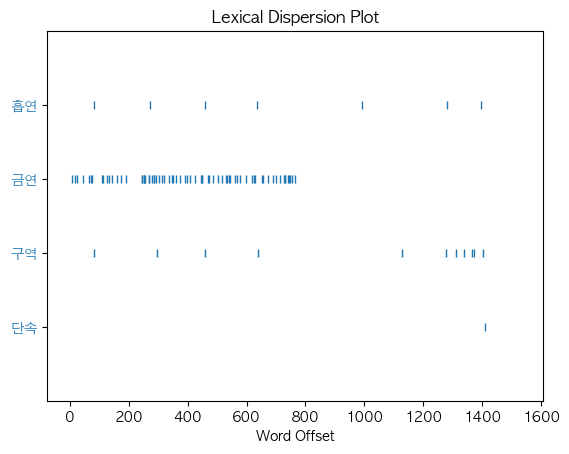

In [47]:
data_text.dispersion_plot(['흡연', '금연', '구역', '단속'])
plt.show()

# RNN

## 전처리

In [48]:
t = Tokenizer()
t.fit_on_texts([word_list])
encoded = t.texts_to_sequences([word_list])[0]
print(encoded)
print(t.word_index)

[2, 135, 39, 17, 136, 2, 1, 5, 12, 9, 6, 8, 13, 2, 14, 30, 1, 10, 18, 15, 11, 19, 51, 137, 2, 1, 5, 12, 6, 8, 13, 2, 14, 30, 89, 90, 138, 139, 2, 7, 40, 72, 31, 32, 6, 1, 16, 38, 33, 46, 52, 65, 34, 6, 8, 13, 2, 14, 30, 2, 7, 31, 32, 6, 47, 1, 5, 66, 140, 53, 33, 91, 1, 26, 1, 54, 55, 17, 31, 32, 6, 92, 48, 27, 93, 7, 28, 23, 73, 49, 26, 34, 67, 23, 15, 11, 19, 94, 41, 68, 6, 8, 13, 2, 14, 69, 141, 142, 2, 1, 5, 12, 236, 1, 10, 18, 15, 11, 51, 143, 237, 144, 2, 135, 39, 95, 2, 1, 5, 12, 41, 1, 10, 7, 28, 145, 23, 18, 96, 67, 15, 11, 19, 33, 1, 34, 7, 28, 23, 74, 97, 75, 146, 41, 68, 6, 8, 13, 2, 14, 69, 1, 10, 18, 15, 11, 19, 147, 20, 33, 148, 149, 1, 16, 38, 98, 99, 100, 16, 47, 5, 76, 77, 150, 151, 56, 77, 238, 24, 1, 70, 152, 42, 152, 42, 77, 150, 151, 239, 57, 58, 56, 153, 154, 59, 240, 241, 78, 242, 243, 58, 155, 244, 245, 8, 246, 56, 24, 101, 7, 28, 46, 156, 157, 56, 153, 154, 59, 247, 78, 58, 155, 59, 248, 56, 249, 250, 251, 252, 253, 254, 158, 159, 1, 10, 53, 1, 70, 74, 255, 1,

In [49]:
print(t.texts_to_sequences(['흡연', '금연']))
print(t.texts_to_sequences(['흡연', '금연'])[0])

[[48], [1]]
[48]


In [50]:
print(t.texts_to_matrix(['흡연', '금연']))
print(t.texts_to_matrix(['흡연', '금연'])[0])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.


In [51]:
for word, value in t.word_index.items():
    if value == 1:
        print('1 : ', word)
        break

1 :  금연


In [52]:
key_to_find = '흡연'
values_with_key = [key for value, key in t.word_index.items() if value == key_to_find]

print(values_with_key)

[48]


In [53]:
# 한글만 남기고 나머지 문자(숫자, 특수문자 등)를 제거하는 함수
def remove_non_korean(sentence):
    return re.sub(r'[^가-힣\s]', '', sentence)

# 문장 리스트에서 한글만 남기고 필터링
filtered_sent_tokens = '.'.join([remove_non_korean(sentence) for sentence in sent_tokens])

# 결과 출력
print(filtered_sent_tokens)

In [54]:
sequences = []
for line in str(filtered_sent_tokens).split('.'):
    print('원본 문장 : ', line)
    encoded = t.texts_to_sequences([line])[0]
    print('encoded된 문장 : ', encoded)
    print()
    for i in range(0, len(encoded)-1):
        for j in range(i+2, len(encoded)+1):
            sequences.append(encoded[i : j])
print('sequences와 해석 : ')
for sequence in sequences:
    print('[', end='')
    for word_seq in sequence:
        for word, value in t.word_index.items():
            if word_seq == value:
                print('{} : {}'.format(word_seq, word), end=' ')
                break
    print(']')

원본 문장 :                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [55]:
sequences

[[17, 136],
 [17, 136, 9],
 [17, 136, 9, 18],
 [17, 136, 9, 18, 139],
 [17, 136, 9, 18, 139, 40],
 [17, 136, 9, 18, 139, 40, 1],
 [17, 136, 9, 18, 139, 40, 1, 16],
 [17, 136, 9, 18, 139, 40, 1, 16, 33],
 [17, 136, 9, 18, 139, 40, 1, 16, 33, 140],
 [17, 136, 9, 18, 139, 40, 1, 16, 33, 140, 53],
 [17, 136, 9, 18, 139, 40, 1, 16, 33, 140, 53, 33],
 [17, 136, 9, 18, 139, 40, 1, 16, 33, 140, 53, 33, 91],
 [17, 136, 9, 18, 139, 40, 1, 16, 33, 140, 53, 33, 91, 55],
 [17, 136, 9, 18, 139, 40, 1, 16, 33, 140, 53, 33, 91, 55, 17],
 [17, 136, 9, 18, 139, 40, 1, 16, 33, 140, 53, 33, 91, 55, 17, 92],
 [17, 136, 9, 18, 139, 40, 1, 16, 33, 140, 53, 33, 91, 55, 17, 92, 93],
 [17, 136, 9, 18, 139, 40, 1, 16, 33, 140, 53, 33, 91, 55, 17, 92, 93, 73],
 [17, 136, 9, 18, 139, 40, 1, 16, 33, 140, 53, 33, 91, 55, 17, 92, 93, 73, 49],
 [17,
  136,
  9,
  18,
  139,
  40,
  1,
  16,
  33,
  140,
  53,
  33,
  91,
  55,
  17,
  92,
  93,
  73,
  49,
  26],
 [17,
  136,
  9,
  18,
  139,
  40,
  1,
  16,
  33,
 

In [56]:
print([len(sequence) for sequence in sequences])

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 2, 3, 4, 5, 6, 7, 8, 9, 10, 2, 3, 4, 5, 6, 7, 8, 9, 2, 3, 4, 5, 6, 7, 8, 2, 3, 4, 5, 6, 7, 2, 3, 4, 5, 6, 2, 3, 4, 5, 2, 3, 4, 2, 3, 2, 2, 3, 4, 5, 6, 7, 8, 2, 3, 4, 5, 6, 7, 2, 3, 4, 5, 6, 2, 3, 4, 5, 2, 3, 4, 2, 3, 2, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 2, 3, 4, 5,

In [57]:
my_len = max([len(sequence) for sequence in sequences])
my_len

38

In [58]:
padded_sequence = pad_sequences(sequences=sequences,
                                maxlen=my_len,
                                padding='pre')
type(padded_sequence), padded_sequence.shape, padded_sequence

(numpy.ndarray,
 (2162, 38),
 array([[  0,   0,   0, ...,   0,  17, 136],
        [  0,   0,   0, ...,  17, 136,   9],
        [  0,   0,   0, ..., 136,   9,  18],
        ...,
        [  0,   0,   0, ...,   0,  50,  16],
        [  0,   0,   0, ...,  50,  16, 133],
        [  0,   0,   0, ...,   0,  16, 133]], dtype=int32))

In [59]:
X = padded_sequence[:, :-1]
y = padded_sequence[:, -1:]

In [60]:
vocab_size = len(t.word_index)
vocab_size

509

In [61]:
Y = to_categorical(y, vocab_size+1)
Y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [62]:
X.shape, Y.shape

((2162, 37), (2162, 510))

## 모델 생성

In [65]:
model = Sequential()

model.add(Embedding(input_dim=vocab_size+1,
                    output_dim=vocab_size-1,
                    input_length=X.shape[1])
)
model.build((None, X.shape[1]))
model.add(SimpleRNN(units=64))
model.add(Dense(units=Y.shape[1], activation='softmax'))
print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 37, 508)        │       259,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 64)             │        36,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 510)            │        33,150 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 328,902 (1.25 MB)

 Trainable params: 328,902 (1.25 MB)

 Non-trainable params: 0 (0.00 B)

None


## 학습과정 설정 및 학습하기

In [66]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
hist = model.fit(x=X, y=Y, epochs=300, verbose=2)

Epoch 1/300
68/68 - 1s - 12ms/step - accuracy: 0.1522 - loss: 5.1472
Epoch 2/300
68/68 - 0s - 6ms/step - accuracy: 0.4167 - loss: 3.4820
Epoch 3/300
68/68 - 0s - 6ms/step - accuracy: 0.5513 - loss: 2.4457
Epoch 4/300
68/68 - 0s - 6ms/step - accuracy: 0.7072 - loss: 1.7946
Epoch 5/300
68/68 - 0s - 6ms/step - accuracy: 0.7937 - loss: 1.3334
Epoch 6/300
68/68 - 0s - 6ms/step - accuracy: 0.8289 - loss: 1.0105
Epoch 7/300
68/68 - 0s - 7ms/step - accuracy: 0.8557 - loss: 0.7939
Epoch 8/300
68/68 - 0s - 7ms/step - accuracy: 0.8770 - loss: 0.6464
Epoch 9/300
68/68 - 0s - 6ms/step - accuracy: 0.8945 - loss: 0.5415
Epoch 10/300
68/68 - 0s - 6ms/step - accuracy: 0.9029 - loss: 0.4651
Epoch 11/300
68/68 - 0s - 6ms/step - accuracy: 0.9098 - loss: 0.4105
Epoch 12/300
68/68 - 0s - 7ms/step - accuracy: 0.9126 - loss: 0.3665
Epoch 13/300
68/68 - 0s - 7ms/step - accuracy: 0.9154 - loss: 0.3320
Epoch 14/300
68/68 - 0s - 7ms/step - accuracy: 0.9181 - loss: 0.3039
Epoch 15/300
68/68 - 0s - 6ms/step - accur

In [67]:
hist.history.keys()

dict_keys(['accuracy', 'loss'])

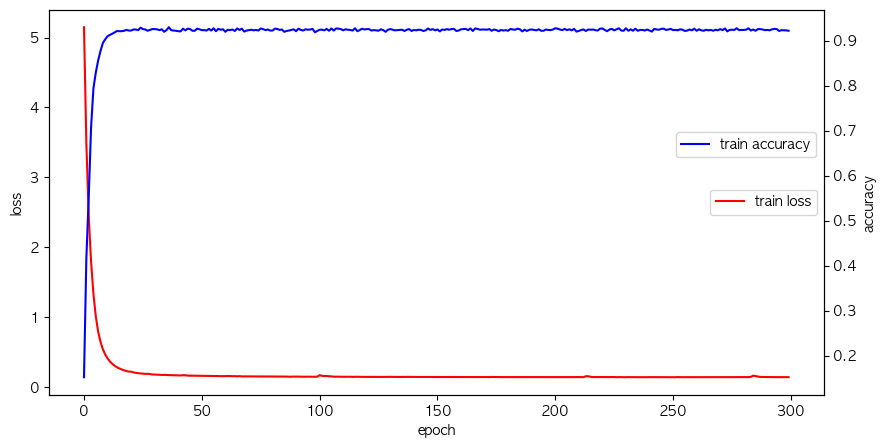

In [68]:
fig, loss_ax = plt.subplots(figsize=(10, 5))
loss_ax.plot(hist.history['loss'], 'r', label='train loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center right')
acc_ax.legend(bbox_to_anchor=(0.999, 0.7))
plt.show()